In [1]:
"""
Worksheet for flood risk model.
Better not restart and run all...
"""

'\nWorksheet for flood risk model.\nBetter not restart and run all...\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import flood_tool.geo
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,LinearRegression,SGDRegressor,SGDClassifier,Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,confusion_matrix,f1_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import naive_bayes
from sklearn.svm import SVR,SVC

In [2]:
# From prob to riskLabel
def classify_y_pred(flood_prob):
    flood_event = np.array([1,0.5,1,5,10,15,20,30,40,50])
    distances = abs(flood_event - flood_prob)
    flood_class = np.argmin(distances) + 1
    return flood_class

"""
From prob to riskLabel
"""
def find_level(pred):
    if (type(pred) is pd.DataFrame) and (type(pred) is not np.ndarray):
        #pred = pd.DataFrame(pred)
        flood_event = pd.DataFrame()
        flood_event['event'] = [1,0.5,1,5,10,15,20,30,40,50]
        flood_event.index = flood_event.index+1
        for i in range(len(pred)):
            distance = abs(flood_event-(pred.iloc[i]))
            distance_argmin = (distance[(distance['event'] == (distance.min())[0])].index)[0]
            pred.iloc[i] = distance_argmin
        pred = pred.reset_index()
        pred.drop(columns='index',inplace=True)
        #pred = pd.Series(pred[0])
        return pred
    else:
        pred = pd.DataFrame(pred)
        flood_event = pd.DataFrame()
        flood_event['event'] = [1,0.5,1.0,5.0,10.,15.,20.,30.,40.,50.]
        flood_event.index = flood_event.index+1
        for i in range(len(pred)):
            distance = abs(flood_event-(pred.iloc[i])[0])
            distance_argmin = (distance[(distance['event'] == (distance.min())[0])].index)[0]
            pred.iloc[i][0] = distance_argmin
        pred = pred.reset_index()
        pred.drop(columns='index',inplace=True)
        #pred = pd.Series(pred[0])
        return pred

### Baseline model for flood risk prediction
1. Baseline models using classification and regression
2. Gridsearch and randomizedsearch
3. Save best model

### Import data

In [5]:
data = pd.read_csv("flood_tool/resources/postcodes_sampled.csv")
data.head()

,postcode,sector,easting,northing,localAuthority,altitude,soilType,riskLabel,medianPrice
0,PO7 8PR,PO7 8,469395.0,108803.0,Havant,30,Planosols,1,233500.0
1,SO17 1NS,SO17 1,442771.0,114321.0,Southampton,20,Unsurveyed/Urban,1,291800.0
2,TN28 8XN,TN28 8,606861.0,124689.0,Folkestone and Hythe,10,Cambisols,1,326500.0
3,KT3 4JW,KT3 4,521649.0,168848.0,Kingston upon Thames,20,Unsurveyed/Urban,1,875200.0
4,CT2 8AA,CT2 8,614532.0,158074.0,Canterbury,10,Unsurveyed/Urban,10,303500.0


In [6]:
features = data[['easting', 'northing', 'localAuthority', 'altitude', 'soilType']]
corr = data[features].corr()
sns.heatmap(corr)


KeyError: ('easting', 'northing', 'localAuthority', 'altitude', 'soilType')

Low correlation, so no need to remove features yet

### Preprocessing

In [5]:
print('Duplicates in data: ',data.duplicated().sum())
print('Nan in data:        ', data.isnull().sum().sum())

Duplicates in data:  0
Nan in data:         0


In [6]:
"""
Convert easting and northing to latitude and longitude
"""
lat_long = np.vstack(geo.get_gps_lat_long_from_easting_northing(data.easting,data.northing))
data.easting = lat_long[0]
data.northing = lat_long[1]

In [7]:
'''
Drop those columns we consider less important for predicting the flood.
We will use: location(easting,northing),altitude,soilType for modelling.
'''
columns_to_drop = ['riskLabel','medianPrice','postcode','sector', 'localAuthority']

# X,y are used in regression
X = data.drop(columns=columns_to_drop)
y = data.riskLabel

# X_c,y_c are used in classification
X_c = X.copy()
y_c = y.copy()

In [8]:
# Replace the risklabel with prob
label_conv_dict = {1: 1, 2: 0.5, 3: 1, 4:5, 5:10, 6:15, 7:20, 8:30, 9:40, 10:50}
y = y.apply(lambda y: label_conv_dict[y])
y.head()

0     1.0
1     1.0
2     1.0
3     1.0
4    50.0
Name: riskLabel, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c,y_c,test_size=0.3,random_state=42)

### Check the outliers

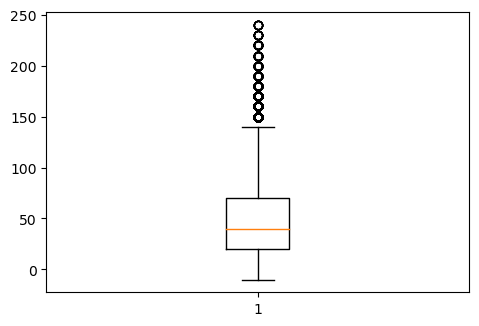

In [10]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.boxplot(X.altitude);
#Nothing strange here:)

### Baseline model (classification)

In [11]:
num_pipe = Pipeline([
    ('num_imputer', SimpleImputer()),
    ('num_scaler', StandardScaler())])

cat_pipe = Pipeline([
    ('cat_imputer',SimpleImputer(strategy = 'most_frequent')),
    ('cat_encoder',OneHotEncoder(handle_unknown='ignore', sparse=True))])

preprocessor = ColumnTransformer([
    ('num_transformer', num_pipe, X_train.select_dtypes(include=np.number).columns),
    ('cat_transformer', cat_pipe, X_train.select_dtypes(exclude=np.number).columns)],
    remainder='passthrough')

In [12]:
classification = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=2500, multi_class='multinomial'))])
classification

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'altitude'], dtype='object')),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=2500, multi_class='multinomial'))])

### Baseline model (regression)

In [13]:
regression = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())])
regression

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'altitude'], dtype='object')),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('regressor', LinearRegression())])

### Test (Baseline model using classification)

In [14]:
classification.fit(X_train_c,y_train_c);

In [15]:
classification.score(X_test_c, y_test_c)

0.9034166666666666

In [16]:
np.mean((cross_validate(classification,X_train_c,y_train_c,cv=5))['test_score'])

0.9022142857142856

In [17]:
confusion_matrix(y_test_c,classification.predict(X_test_c))

array([[10820,     0,     0,    27,     0,     0,     0,     0,     0,
            0],
       [   36,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [   43,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  418,     0,     0,    21,     0,     0,     0,     0,     0,
            0],
       [   76,     0,     0,     1,     0,     0,     0,     0,     0,
            0],
       [  273,     0,     0,     8,     0,     0,     0,     0,     0,
            0],
       [   65,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  138,     0,     0,     1,     0,     0,     0,     0,     0,
            0],
       [   30,     0,     0,     1,     0,     0,     0,     0,     0,
            0],
       [   41,     0,     0,     1,     0,     0,     0,     0,     0,
            0]])

### Test (Baseline model using regression)

In [18]:
regression.fit(X_train,y_train);

In [19]:
regression.score(X_test, y_test)

0.04508680218553629

In [20]:
np.mean((cross_validate(regression,X_train,y_train,cv=10))['test_score'])

0.03460121291922911

In [21]:
y_pred = regression.predict(X_test);

In [22]:
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
rsquared = r2_score(y_test, y_pred)
print('The scores of baseline model(regression) are:')
print('MSE =', round(mse, 2))
print('RMSE =', round(rmse, 2))
print('MAE =', round(mae, 2))
print('R2 =', round(rsquared, 2))

The scores of baseline model(regression) are:
MSE = 26.91
RMSE = 5.19
MAE = 2.17
R2 = 0.05


### Find best estimator and param

*classification search*

In [23]:
grid = {'classifier':(LogisticRegression(max_iter=3000),
                      DecisionTreeClassifier(),
                      RandomForestClassifier(),
                      KNeighborsClassifier(),
                      SGDClassifier(),SVC())}
classification_search = GridSearchCV(classification,param_grid=grid,scoring='r2',n_jobs=-1)
classification_search.fit(X_train_c,y_train_c);

In [24]:
print('Best params:',classification_search.best_params_['classifier'])
print('Best score: ',classification_search.best_score_)
best_classification = classification_search.best_estimator_

Best params: RandomForestClassifier()
Best score:  0.10921697870515075


*regression search*

In [25]:
grid_regression = {'regressor':(LinearRegression(),
                                 SGDRegressor(),
                                 KNeighborsRegressor(),
                                 SVR(),Lasso(),
                                 RandomForestRegressor())}
regression_search = GridSearchCV(regression,param_grid=grid_regression,scoring='r2',n_jobs=-1)
regression_search.fit(X_train,y_train);

In [26]:
print('Best score: ',regression_search.best_score_)
print('Best params:',regression_search.best_params_['regressor'])
best_regression = regression_search.best_estimator_

Best score:  0.20017472306522296
Best params: RandomForestRegressor()


In [27]:
y_pred = best_regression.predict(X_test);

In [28]:
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
rsquared = r2_score(y_test, y_pred)
print('The scores of best_regression are:')
print('MSE =', round(mse, 2))
print('RMSE =', round(rmse, 2))
print('MAE =', round(mae, 2))
print('R2 =', round(rsquared, 2))

The scores of best_regression are:
MSE = 21.98
RMSE = 4.69
MAE = 1.48
R2 = 0.22


### Temp conclusion:
*Regression*

In [29]:
best_regression

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'altitude'], dtype='object')),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('regressor', RandomForestRegressor())])

### Find best params for RandomForestRegressor

In [30]:
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 700, num = 40)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(20, 100, num = 80)]
min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [1, 2, 4,6]
bootstrap = [True, False]

random_grid = {'regressor__n_estimators': n_estimators,
               'regressor__max_depth': max_depth,
               'regressor__min_samples_split': min_samples_split,
               'regressor__min_samples_leaf': min_samples_leaf,
               'regressor__bootstrap': bootstrap}

In [31]:
"""
Comment all the codes below so that people won't run this search by accident.
"""

# final_search = RandomizedSearchCV(best_regression,
#                             param_distributions=random_grid,
#                             n_iter=100,
#                             random_state=42,
#                             cv = 2,
#                             verbose=2,
#                             n_jobs=-1,
#                             scoring='r2');
# final_search.fit(X_train,y_train);

Fitting 2 folds for each of 100 candidates, totalling 200 fits


In [32]:
print('Best score: ',final_search.best_score_)
print('Best params:',final_search.best_params_)

Best score:  0.16999805434769255
Best params: {'regressor__n_estimators': 402, 'regressor__min_samples_split': 6, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 71, 'regressor__bootstrap': True}


In [33]:
final_pipeline = final_search.best_estimator_

### Check our model

In [34]:
y_pred = final_pipeline.predict(X_test)

In [35]:
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
rsquared = r2_score(y_test, y_pred)
print('The scores of final model are:')
print('MSE =', round(mse, 2))
print('RMSE =', round(rmse, 2))
print('MAE =', round(mae, 2))
print('R2 =', round(rsquared, 2))

The scores of final model are:
MSE = 21.33
RMSE = 4.62
MAE = 1.53
R2 = 0.24


In [36]:
y_true = (pd.DataFrame(y_test).reset_index())

In [37]:
y_true.drop(columns='index',inplace=True)

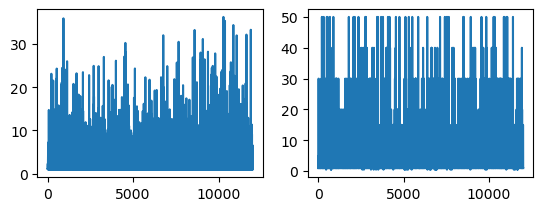

In [38]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.plot(y_pred);

plt.subplot(2, 2, 2)
plt.plot(y_true);

In [39]:
y_pred_label = pd.Series(y_pred).apply(lambda y: classify_y_pred(y))
y_test_level = find_level(y_test)

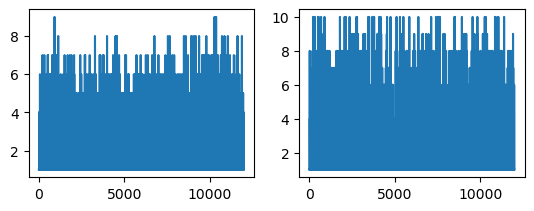

In [40]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.plot(y_pred_label);

plt.subplot(2, 2, 2)
plt.plot(y_test_level);

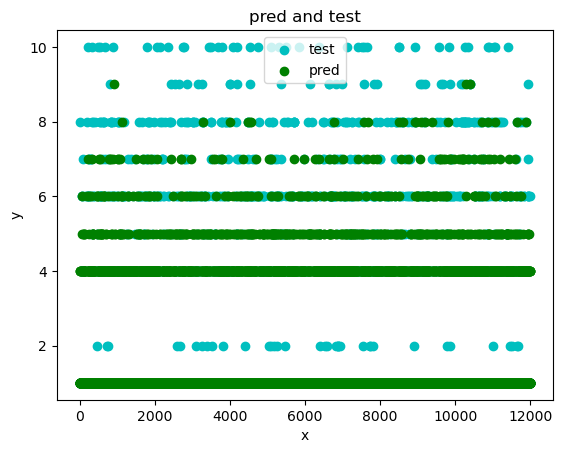

In [41]:
x =np.linspace(0,12000,12000)
x1 = x
y1 = y_test_level['riskLabel']
x2 = x
y2 = y_pred_label
plt.scatter(x1, y1, label = 'test', color='c')
plt.scatter(x2, y2, label = 'pred', color='g')
plt.title('pred and test')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
# Print the chart
plt.show()

In [42]:
y_pred_label.value_counts()

1    9936
4    1478
5     368
6     125
7      68
8      22
9       3
dtype: int64

In [47]:
y_test_level.value_counts()

riskLabel
1.0          10890
4.0            439
6.0            281
8.0            139
5.0             77
7.0             65
10.0            42
2.0             36
9.0             31
dtype: int64

### Use the scores from test_scorable.py

In [72]:
SCORES = np.array([[100, 80, 60, 60, 30, 0, -30, -600, -1800, -2400],
                   [80, 100, 80, 90, 60, 30, 0, -300, -1200, -1800],
                   [60, 80, 100, 120, 90, 60, 30, 0,  -600, -1200],
                   [40, 60, 80,  150, 120, 90, 60, 300, 0, -600],
                   [20, 40, 60, 120, 150, 120, 90, 600, 600, 0],
                   [0, 20, 40, 90, 120, 150, 120, 900, 1200, 600],
                   [-20, 0, 20, 60, 90, 120, 150, 1200, 1800, 1200],
                   [-40, -20, 0, 30, 60, 90, 120, 1500, 2400, 1800],
                   [-60, -40, -20, 0, 30, 60, 90, 1200, 3000, 2400],
                   [-80, -60, -40, -30, 0, 30, 60, 900, 2400, 3000]])

def score_prediction(predicted, truth):
    return sum([SCORES[_p-1, _t-1]
                for _p, _t in zip(predicted, truth)])

In [73]:
truth = pd.Series(y_test_level.riskLabel)
truth = truth.astype(int)

In [74]:
our_score = score_prediction(y_pred_label,truth)/score_prediction(truth,truth)

In [80]:
print('Our score is:',our_score,'/ 1.0')

Our score is: 0.7015157026797624 / 1.0


In [81]:
#Don't run this block every time, double check before rewrite the pkl file.
#pickle.dump(final_pipeline, open('risklabel_pipeline.pkl','wb'));

In [82]:
#Now we have saved our best model.